In [79]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
from urllib.parse import urlparse
from spacy import load
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('wordnet2022')
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet2022 to /root/nltk_data...
[nltk_data]   Package wordnet2022 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [80]:
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.utils import pad_sequences
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

In [81]:
df = pd.read_csv("/content/drive/MyDrive/Stress/Stress.csv")
df.head()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005


In [82]:
df["subreddit"].value_counts()

ptsd                584
relationships       552
anxiety             503
domesticviolence    316
assistance          289
survivorsofabuse    245
homeless            168
almosthomeless       80
stress               64
food_pantry          37
Name: subreddit, dtype: int64

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subreddit         2838 non-null   object 
 1   post_id           2838 non-null   object 
 2   sentence_range    2838 non-null   object 
 3   text              2838 non-null   object 
 4   label             2838 non-null   int64  
 5   confidence        2838 non-null   float64
 6   social_timestamp  2838 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 155.3+ KB


## Dropping Unneccesary columns

In [84]:
not_used_cols = ['subreddit','post_id','sentence_range','confidence','social_timestamp']
df1 = df.drop(not_used_cols,axis=1)

In [85]:
df1.head()

,text,label
0,"He said he had not felt that way before, sugge...",1
1,"Hey there r/assistance, Not sure if this is th...",0
2,My mom then hit me with the newspaper and it s...,1
3,"until i met my new boyfriend, he is amazing, h...",1
4,October is Domestic Violence Awareness Month a...,1


## Data Analysis

<Axes: xlabel='label', ylabel='count'>

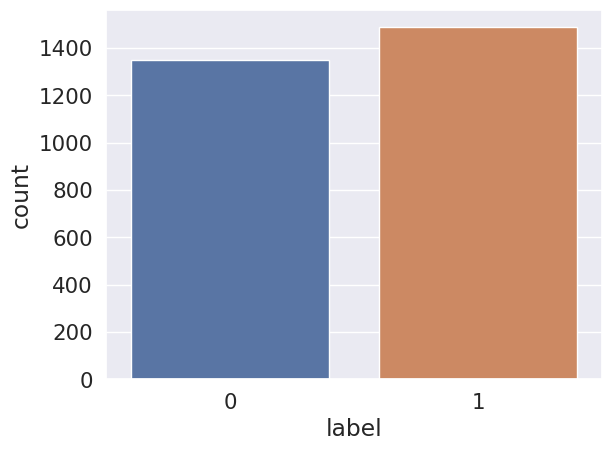

In [86]:
sns.set_style("darkgrid")
sns.countplot(data=df,x=df.label)

### We can see that the dataset is balanced.

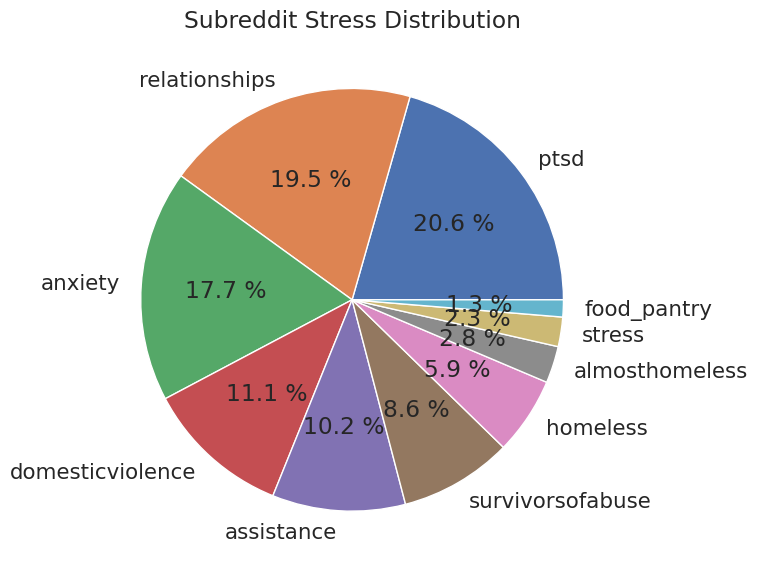

In [87]:
context=['subreddit']
plt.figure(figsize=(15,12))
for i in range(len(context)):
    plt.subplot(1,2,i+1)
    a=df[context[i]].value_counts()
    title=a.index
    plt.title("Subreddit Stress Distribution")
    plt.pie(x=a,labels=title,autopct="%.1f %%")
    plt.show()

### We can see that the distribution of stress was mostly from PTSD disorder and relationships

### Text Preprocessing

In this section, we perform text preprocessing on the DataFrame's text data. Text preprocessing involves cleaning and standardizing the text for analysis.

**Function `textPocess`**

1. **Function Definition**: The `textPocess` function is defined for text preprocessing.


2. **Text Cleaning Steps**: It includes steps like bracket removal, URL removal, escaped character removal, HTML tag removal, alphanumeric character retention, lowercase conversion, word tokenization, stopword removal, and lemmatization.

3. **Error Handling**: The function handles exceptions.

**Applying Preprocessing to DataFrame**

4. **Applying `textPocess`**: The function is applied to the 'text' column of the DataFrame `df1`, and cleaned text is stored in 'processed_text.'

5. **Displaying Processed Text**: Examples of text before and after processing are shown.

Text preprocessing ensures that the text data is cleaned, standardized, and ready for analysis or modeling.

In [88]:
lemmatizer = WordNetLemmatizer()
stop_words = list(stopwords.words('english'))
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [89]:
def textProcess(sent):
    try:
        # Replace brackets with space
        sent = re.sub(r'[][)(]', ' ', sent)

        # Remove URLs
        sent = ' '.join(word for word in sent.split() if not urlparse(word).scheme)

        # Remove escape characters
        sent = re.sub(r'@\w+', '', sent)

        # Remove HTML tags
        sent = BeautifulSoup(sent, "html.parser").get_text()

        # Keep only letters and numbers
        sent = re.sub("[^A-Za-z0-9]", ' ', sent)

        # Convert to lowercase
        sent = sent.lower()

        # Tokenize the text
        tokens = word_tokenize(sent)

        # Remove stopwords
        tokens = [word for word in tokens if word not in stop_words]

        # Lemmatize words
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

        # Join the tokens back into a single string
        sent = ' '.join(tokens)

        return sent
    except Exception as ex:
        print(sent, "\n")
        print("Error ", ex)

# Assuming df1 is a DataFrame, apply the text processing function to the 'text' column
df1['processed_text'] = df1['text'].apply(lambda text: textProcess(text))

<ipython-input-89-915c7763fc22>:13: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sent = BeautifulSoup(sent, "html.parser").get_text()


In [90]:
print("without process ----> ",df1['text'].iloc[23],end='\n\n')
print("after process ----> ",df1['processed_text'].iloc[23])

without process ---->  With a switch blade and open arms In a sweater vest that covers a ragged undershirt stained with my innocence Through faces that are never the same as the ones I dread finding in the crowd In the night, I rediscover my love of mares and how hoarse I can be in the morning It's the taste of blood but I am not bleeding

after process ---->  switch blade open arm sweater vest cover ragged undershirt stained innocence face never one dread finding crowd night rediscover love mare hoarse morning taste blood bleeding


## Wordcloud

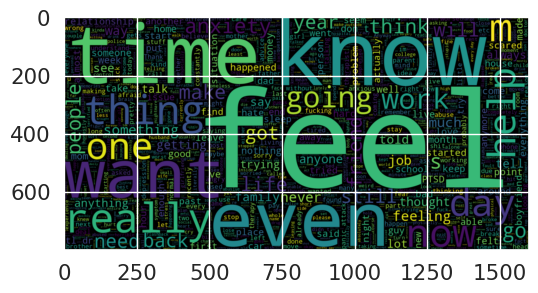

In [91]:
plt.figure(figsize = (6,6)) # User Having Stress
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df1[df1.label == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

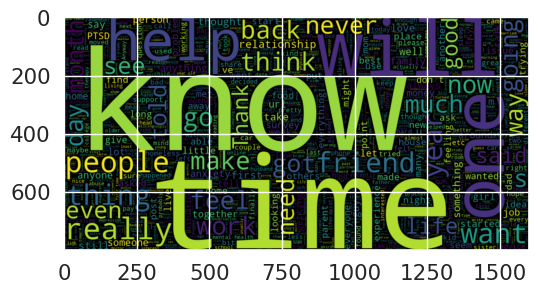

In [92]:
plt.figure(figsize = (6,6)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df1[df1.label == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

## Word Count

In [93]:
def get_corpus(text):
  words=[]
  for i in text:
    for j in i.split():
      words.append(j.strip())
  return words
corpus=get_corpus(df1['processed_text'])

In [94]:
from collections import Counter
counter=Counter(corpus)
most_common=counter.most_common(20)
most_common=dict(most_common)

In [95]:
print("Top 20 most used words")
for i,j in most_common.items():
  print("Word: {} --> Count: {}".format(i,j))

Top 20 most used words
Word: like --> Count: 1206
Word: time --> Count: 959
Word: get --> Count: 930
Word: know --> Count: 919
Word: feel --> Count: 853
Word: would --> Count: 757
Word: year --> Count: 708
Word: really --> Count: 651
Word: want --> Count: 646
Word: even --> Count: 600
Word: one --> Count: 599
Word: help --> Count: 584
Word: go --> Count: 565
Word: thing --> Count: 561
Word: day --> Count: 550
Word: friend --> Count: 523
Word: people --> Count: 487
Word: back --> Count: 464
Word: going --> Count: 458
Word: work --> Count: 441


## Trigram Analysis

In [96]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus,n,g):
  vec=CountVectorizer(ngram_range=(g,g)).fit(corpus)
  bag_of_words=vec.transform(corpus)
  sum_words=bag_of_words.sum(axis=0)
  words_freq=[(word,sum_words[0,idx]) for word ,idx in vec.vocabulary_.items()]
  words_freq=sorted(words_freq,key=lambda x:x[1],reverse=True)
  return words_freq[:n]

<Axes: >

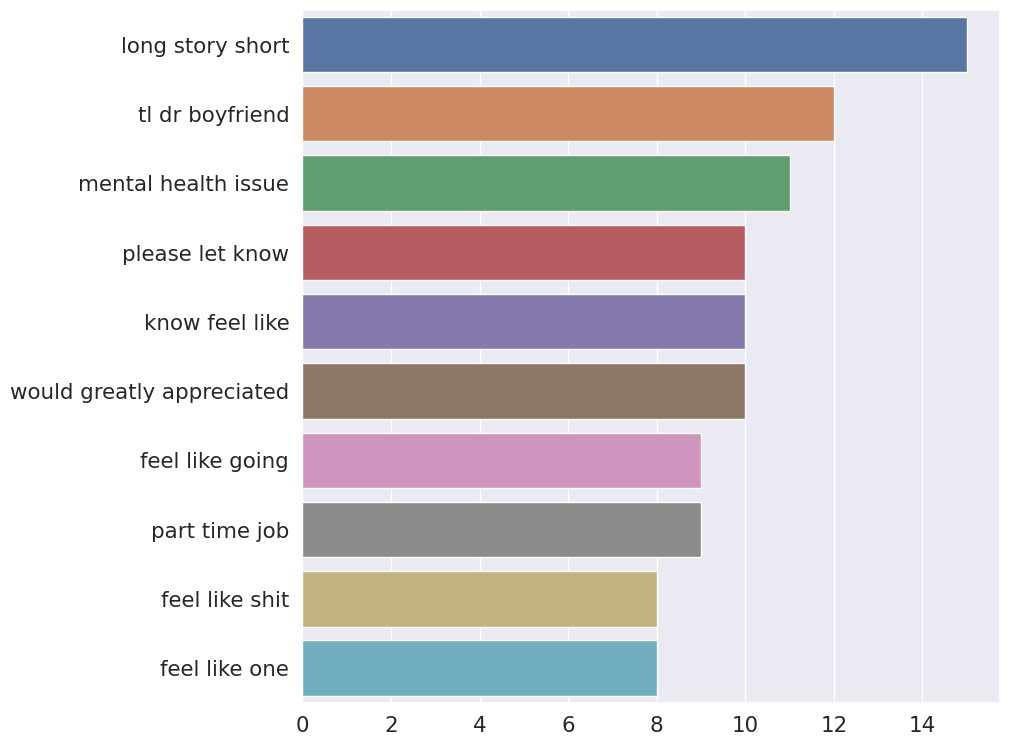

In [97]:
plt.figure(figsize=(9,9))
most_common_tri=get_top_text_ngrams(df1['processed_text'],10,3)
most_common_tri=dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))

## Text Vectorization

In this section, we convert text data into numerical form for machine learning.


#### TF-IDF Vectorization

4. **Initialization**: We create a TF-IDF Vectorizer with `MIN_DF = 1`.

5. **Vectorization**: Using this vectorizer, we transform the 'processed_text' column into a matrix where rows are documents, columns are unique words, and values are TF-IDF scores.

6. **Conversion**: We convert the TF-IDF sparse matrix into a DataFrame.

This process prepares text data for machine learning analysis by representing it numerically.


In [116]:
from sklearn.feature_extraction.text import TfidfVectorizer
MIN_DF = 1
tf = TfidfVectorizer(min_df=MIN_DF)
tf_df = tf.fit_transform(df1['processed_text'])
tf_df.toarray()
tf_df = pd.DataFrame(tf_df.toarray(),columns=tf.get_feature_names_out())
tf_df.head(3)
# print(tf_df.describe())
tf_df.shape

(2838, 10139)

In [117]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Input, Concatenate, Attention


In [118]:
X_train,X_test,y_train,y_test = train_test_split(tf_df,df1['label'],stratify=df1['label'],test_size=0.25)

## Logistic Regression Model

Accuracy: 0.74
Precision: 0.73
Recall: 0.80
F1 Score: 0.77


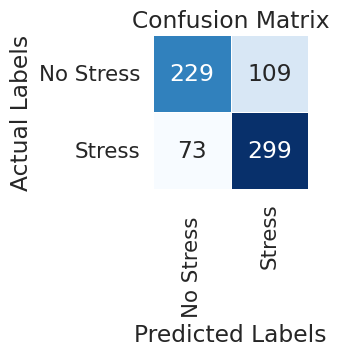

In [119]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_lr.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


# Create a DataFrame for the confusion matrix for better visualization
confusion_df = pd.DataFrame(conf_matrix, index=['No Stress', 'Stress'], columns=['No Stress  ', 'Stress'])

# Create a cool-looking heatmap using seaborn and matplotlib
plt.figure(figsize=(2,2))
sns.set(font_scale=1.4)  # Adjust font size as needed
sns.heatmap(confusion_df, annot=True, fmt='g', cmap="Blues", cbar=False, linewidths=0.5)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

## Random Forest Classifier

Accuracy: 0.71
Precision: 0.68
Recall: 0.83
F1 Score: 0.75


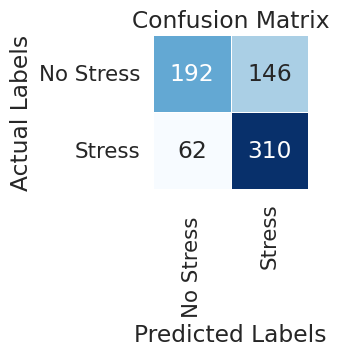

In [120]:
from sklearn.ensemble import RandomForestClassifier

model2 = RandomForestClassifier()
model2.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model2.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Create a DataFrame for the confusion matrix for better visualization
confusion_df = pd.DataFrame(conf_matrix, index=['No Stress', 'Stress'], columns=['No Stress  ', 'Stress'])

# Create a cool-looking heatmap using seaborn and matplotlib
plt.figure(figsize=(2,2))
sns.set(font_scale=1.4)  # Adjust font size as needed
sns.heatmap(confusion_df, annot=True, fmt='g', cmap="Blues", cbar=False, linewidths=0.5)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

## LSTM model

In [103]:
# Tokenization and padding
max_words = 1000  # Maximum number of words in your vocabulary
max_sequence_length = 300  # Maximum length of a sequence
embedding_dim = 100  # Dimension of word embeddings

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df1['text'])
sequences = tokenizer.texts_to_sequences(df1['text'])
X = pad_sequences(sequences, maxlen=max_sequence_length)

# Convert labels to a numpy array
y = np.array(df1["label"])


In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [105]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(64))
 # You can adjust the number of LSTM units as needed
model.add(Dense(1, activation='sigmoid'))  # Sigmoid activation for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

Epoch 1/10
71/71 [==============================] - 19s 243ms/step - loss: 0.6222 - accuracy: 0.6419 - val_loss: 0.5539 - val_accuracy: 0.7007
Epoch 2/10
71/71 [==============================] - 16s 225ms/step - loss: 0.4605 - accuracy: 0.7890 - val_loss: 0.5663 - val_accuracy: 0.7377
Epoch 3/10
71/71 [==============================] - 16s 232ms/step - loss: 0.3772 - accuracy: 0.8476 - val_loss: 0.6152 - val_accuracy: 0.7113
Epoch 4/10
71/71 [==============================] - 17s 233ms/step - loss: 0.3711 - accuracy: 0.8463 - val_loss: 0.6185 - val_accuracy: 0.7077
Epoch 5/10
71/71 [==============================] - 18s 257ms/step - loss: 0.2873 - accuracy: 0.8899 - val_loss: 0.6471 - val_accuracy: 0.7289
Epoch 6/10
71/71 [==============================] - 16s 229ms/step - loss: 0.2471 - accuracy: 0.9070 - val_loss: 0.6782 - val_accuracy: 0.7201
Epoch 7/10
71/71 [==============================] - 17s 234ms/step - loss: 0.1956 - accuracy: 0.9313 - val_loss: 0.7332 - val_accuracy: 0.7218

## testing the model

We have defined a function called `predictor` that takes a text input, processes it, and then uses our trained machine learning model to predict whether the person expressing that text is in stress or not.

#### How It Works

1. **Text Processing**: The input text is processed to remove unnecessary characters, tokenize it, and apply lemmatization. This makes the text suitable for analysis.

2. **Feature Transformation**: The processed text is transformed into numerical features using a TF-IDF vectorizer. This step converts the text into a format that the machine learning model can understand.

3. **Prediction**: The transformed text is passed through a logistic regression model (`model`). This model has been trained on labeled data to make predictions. The result of this prediction is stored in the `res` variable.

4. **Interpreting the Result**:
   - If `res` is equal to 1, the model predicts "Person is in stress." This means that the input text is indicative of stress based on patterns it has learned.
   - If `res` is equal to 0, the model predicts "Person is not in stress." This suggests that the input text does not exhibit signs of stress according to the model's analysis.

This function is valuable for assessing the emotional tone of text data and determining if individuals are expressing stress-related sentiments in their messages.

In [106]:
def predictor(text):
    processed = textProcess(text)
    embedded_words = tf.transform([text])
    res = model_lr.predict(embedded_words)
    if res[0] == 1:
        res = "Person is in stress"
    else:
        res = "Person is not in stress"
    return res

In [112]:
text = "I am not eating much, and worried about the final exams."
text1 = "I've been having trouble sleeping, and I'm often irritable."
text2 = "I've been having trouble sleeping, and I'm often irritable, I've been neglecting my hobbies and social life."
text3 = "I've been feeling overwhelmed lately. I've been having trouble sleeping, and I'm often irritable, I've been neglecting my hobbies and social life."
text4 = "happy life going on"

print(predictor(text))
print(predictor(text1))
print(predictor(text2))
print(predictor(text3))
print(predictor(text4))

Person is in stress
Person is not in stress
Person is not in stress
Person is in stress
Person is not in stress


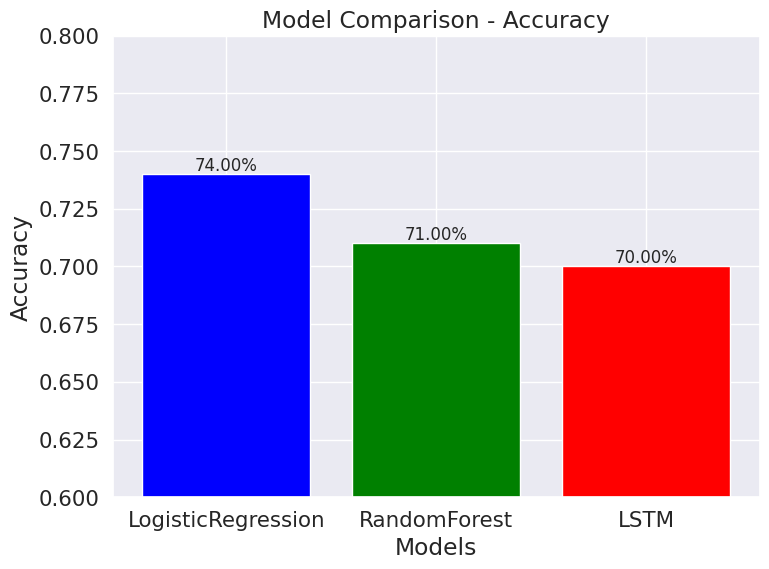

In [124]:
import matplotlib.pyplot as plt

# Model names and corresponding accuracy scores
models = ['LogisticRegression', 'RandomForest', 'LSTM']
accuracies = [0.74, 0.71, 0.70]

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Comparison - Accuracy')
plt.ylim(0.6, 0.8)  # Adjust the y-axis limits if needed

# Show the accuracy scores on top of the bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc, f'{acc:.2%}', ha='center', va='bottom', fontsize=12)

# Display the chart
plt.tight_layout()
plt.show()


In [125]:
df_scrapped = pd.read_excel("/content/sample_data/Scrapped_data_Stress.xlsx")


In [126]:
df_scrapped.head()

,Unnamed: 0,Title,Content
0,0,"Free Covid-19 Anxiety e-Workbook. Please, take...",NaN
1,1,I shouldn’t be Stressed,"I’m financially Stable, I don’t really have to..."
2,2,"Life is suffering, unironically",I live in a tiny cramped apartment with abusiv...
3,3,FREE 15 MINUTE BURNOUT COACHING IN RETURN FOR ...,"Hi everyone,Do you want to overcome stress and..."
4,4,Dealing with college stress makes me suicidal,I have little reason to be depressed but I am ...


In [127]:
df_scrapped.drop(columns = ["Unnamed: 0"], inplace = True)

## Testing our model from scrapped data

In [128]:
df_scrapped["Content"][2]

"I live in a tiny cramped apartment with abusive parents that I hate, I have virtually no time to myself, I can barely spend a handful of hours per week with the 2 friends I have, I haven't gotten a normal amount of sleep in literal years, I live in a backwards country with no prospects for the future and education takes up most of my time. I'm always stressed out because of all of the above and I don't know what to do. I'm writing this as a result of the latest meltdown I've had due to my parents. Please help me."

In [129]:
print(predictor(df_scrapped["Content"][2]))

Person is in stress


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
